In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import h5py
from pathlib import Path
from tqdm import tqdm
from scipy.signal import convolve2d, convolve

In [3]:
BASE_DIR = Path("/home/roblesee/dune/hpst/data/sim_data/train")
NUMU_DIRECTORY = BASE_DIR / "argon_cubic_production"
NUE_DIRECTORY = BASE_DIR / "argon_cubic_production"

numu_files = list(NUMU_DIRECTORY.glob("argon_cubic_numu_production_*.h5"))
nue_files = list(NUE_DIRECTORY.glob("argon_cubic_nue_production_*.h5"))

In [4]:
class_names = {
    "Other": np.inf,
    "Electron": 11,
    "Muon": 13,
    "Proton": 2212,
    "Neutron": 2112,
    "Charged Pion": 211,
    "Neutral Pion": 111,
    "Charged Kaon": 321,
    #"Photon": 22
}

class_ids = np.asarray(list(class_names.values()))

In [5]:
def plot_sample(eid):
    mask = evtid == eid
    #print(np.unique(pdgs[mask][classes[mask] == 0]))
    #mask &= edep > 0.05
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=9)
    scale = 10
    #fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(scale*5,scale*5))
    #coord_range_z = coords[mask, 2].min(), coords[mask, 2].max()
    #coord_range_x = coords[mask, 0].min(), coords[mask, 0].max()
    #bins_z = (coord_range_z[1] - coord_range_z[0]) // 5
    #bins_x = (coord_range_x[1] - coord_range_x[0]) // 5
    #mat = np.zeros((int(bins_z)+1, int(bins_x)+1))
    coord_range = coords[mask].min(axis=0), coords[mask].max(axis=0)
    bins = ((coord_range[1] - coord_range[0]) // 5 + 1).astype(int)
    
    energy_agg = np.zeros((9, *bins))
    energy_agg_true = np.zeros((9, *bins))
    pixel_coords = ((coords[mask] - coords[mask].min(axis=0, keepdims=True)) // 5).astype(int)
    
    np.add.at(energy_agg, (classes[mask]+1, pixel_coords[:,0], pixel_coords[:,1], pixel_coords[:,2]), edep[mask])
    np.add.at(energy_agg_true, (trueclasses[mask]+1, pixel_coords[:,0], pixel_coords[:,1], pixel_coords[:,2]), edep[mask])
    
    neighbor_energy = energy_agg.sum(axis=0)
    neighbor_energy[neighbor_energy < 0.05] = 0
    agged_energy = convolve(neighbor_energy, [[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,0,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]]], mode='same')
    
    neighbor_energy_true = energy_agg_true.sum(axis=0)
    neighbor_energy_true[neighbor_energy_true < 0.05] = 0
    agged_energy_true = convolve(neighbor_energy_true, [[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,0,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]]], mode='same')
    
    mat = np.argmax(energy_agg, axis=0)
    mat[energy_agg.sum(axis=0) < 0.05] = 0
    mat[agged_energy < 0.2] = 0
    
    mat_true = np.argmax(energy_agg_true, axis=0)
    mat_true[energy_agg_true.sum(axis=0) < 0.05] = 0
    mat_true[agged_energy_true < 0.2] = 0
    
    coordx,coordy,coordz = np.nonzero(mat)
    aggclass = mat[coordx,coordy,coordz]
    aggenergy = energy_agg.max(axis=0)[coordx,coordy,coordz]
    
    coordx_true,coordy_true,coordz_true = np.nonzero(mat_true)
    aggclass_true = mat_true[coordx_true,coordy_true,coordz_true]
    aggenergy_true = energy_agg.max(axis=0)[coordx_true,coordy_true,coordz_true]
    
    
    mat2d = np.zeros((agged_energy.shape[2], agged_energy.shape[0]))
    mat2d_true = np.zeros((agged_energy_true.shape[2], agged_energy_true.shape[0]))
    
    mat2d[coordz, coordx] = aggclass
    mat2d_true[coordz_true, coordx_true] = aggclass_true
    
    scale = 10
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(scale*10,scale*3))
    
    ax = axs[0]
    mat2d[mat2d == 0] = np.nan
    ax.set_title("Parent particles")
    im = ax.matshow(mat2d.T, cmap=targets_cmap, vmin=-0.5, vmax=8.5)
    ax.invert_yaxis()
    
    cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7, 8], ax=ax)
    cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])
    
    ax = axs[1]
    ax.set_title("Final particles")
    mat2d_true[mat2d_true == 0] = np.nan
    im = ax.matshow(mat2d_true.T, cmap=targets_cmap, vmin=-0.5, vmax=8.5)
    ax.invert_yaxis()
    
    cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7, 8], ax=ax)
    cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])
    plt.suptitle(f"Sample {eid}")
    plt.show()

In [6]:
def plot_sample_instances(eid):
    mask = evtid == eid
    #print(np.unique(pdgs[mask][classes[mask] == 0]))
    #mask &= edep > 0.05
    targets_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("targets", colors=["#FFFFFF", "#000000", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", '#8c564b', '#e377c2'], N=9)
    scale = 10
    #fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(scale*5,scale*5))
    #coord_range_z = coords[mask, 2].min(), coords[mask, 2].max()
    #coord_range_x = coords[mask, 0].min(), coords[mask, 0].max()
    #bins_z = (coord_range_z[1] - coord_range_z[0]) // 5
    #bins_x = (coord_range_x[1] - coord_range_x[0]) // 5
    #mat = np.zeros((int(bins_z)+1, int(bins_x)+1))
    coord_range = coords[mask].min(axis=0), coords[mask].max(axis=0)
    bins = ((coord_range[1] - coord_range[0]) // 5 + 1).astype(int)
    
    energy_agg = np.zeros((9, *bins))
    energy_agg_true = np.zeros((9, *bins))
    pixel_coords = ((coords[mask] - coords[mask].min(axis=0, keepdims=True)) // 5).astype(int)
    
    np.add.at(energy_agg, (classes[mask]+1, pixel_coords[:,0], pixel_coords[:,1], pixel_coords[:,2]), edep[mask])
    np.add.at(energy_agg_true, (trueclasses[mask]+1, pixel_coords[:,0], pixel_coords[:,1], pixel_coords[:,2]), edep[mask])
    
    neighbor_energy = energy_agg.sum(axis=0)
    neighbor_energy[neighbor_energy < 0.05] = 0
    agged_energy = convolve(neighbor_energy, [[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,0,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]]], mode='same')
    
    neighbor_energy_true = energy_agg_true.sum(axis=0)
    neighbor_energy_true[neighbor_energy_true < 0.05] = 0
    agged_energy_true = convolve(neighbor_energy_true, [[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,0,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]]], mode='same')
    
    mat = np.argmax(energy_agg, axis=0)
    mat[energy_agg.sum(axis=0) < 0.05] = 0
    mat[agged_energy < 0.2] = 0
    
    mat_true = np.argmax(energy_agg_true, axis=0)
    mat_true[energy_agg_true.sum(axis=0) < 0.05] = 0
    mat_true[agged_energy_true < 0.2] = 0
    
    coordx,coordy,coordz = np.nonzero(mat)
    aggclass = mat[coordx,coordy,coordz]
    aggenergy = energy_agg.max(axis=0)[coordx,coordy,coordz]
    
    coordx_true,coordy_true,coordz_true = np.nonzero(mat_true)
    aggclass_true = mat_true[coordx_true,coordy_true,coordz_true]
    aggenergy_true = energy_agg.max(axis=0)[coordx_true,coordy_true,coordz_true]
    
    
    mat2d = np.zeros((agged_energy.shape[2], agged_energy.shape[0]))
    mat2d_true = np.zeros((agged_energy_true.shape[2], agged_energy_true.shape[0]))
    
    mat2d[coordz, coordx] = aggclass
    mat2d_true[coordz_true, coordx_true] = aggclass_true
    
    scale = 10
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(scale*10,scale*3))
    
    ax = axs[0]
    mat2d[mat2d == 0] = np.nan
    ax.set_title("Parent particles")
    im = ax.matshow(mat2d.T, cmap=targets_cmap, vmin=-0.5, vmax=8.5)
    ax.invert_yaxis()
    
    cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7, 8], ax=ax)
    cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])
    
    ax = axs[1]
    ax.set_title("Final particles")
    mat2d_true[mat2d_true == 0] = np.nan
    im = ax.matshow(mat2d_true.T, cmap=targets_cmap, vmin=-0.5, vmax=8.5)
    ax.invert_yaxis()
    
    cbar = fig.colorbar(im, ticks=[0,1,2,3,4,5,6,7, 8], ax=ax)
    cbar.ax.set_yticklabels(["Background", "Other", "Electron", "Muon", "Proton", "Neutron", "Charged Pion", "Neutral Pion", "Charged Kaon"])
    plt.suptitle(f"Sample {eid}")
    plt.show()

In [6]:
data_file = nue_files[100]
with h5py.File(data_file, 'r') as file:
    pdgs = np.abs(file["g4_data_0"]["pdg"][:])
    cross_comp = np.abs(file["g4_data_0"]["pdg"][:]) == np.expand_dims(class_ids, axis=0)
    mask = cross_comp.any(axis=1)
    classes = cross_comp.argmax(axis=1)

    coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
    evtid = file["g4_data_0"]["evtid"][:,0]
    pid = file["g4_data_0"]["pid"][:,0]
    prongs = file["g4_data_0"]["tid"][:,0]
    trueprongs = file["g4_data_0"]["tid"][:,0]
    edep = file["g4_data_0"]["step_edep"][:,0]
    t = file["g4_data_0"]["step_no"][:,0]
    trueclasses = classes.copy()

    if True:
        for i in range(evtid.max() + 1):
            mask = evtid == i

            parents = np.zeros((np.unique(prongs[mask]).max()+1,))
            parents[prongs[mask]] = pid[mask]

            #print(np.unique(classes[mask][parents[prongs[mask]] == 0]))
            #print(np.unique(pdgs[mask][parents[prongs[mask]] == 0]))
            
            parentclasses = np.zeros((np.unique(prongs[mask]).max()+1,))
            parentclasses[prongs[mask]] = classes[mask]

            parents = parents.astype(int)
            parentclasses = parentclasses.astype(int)

            recursiveparent = parents.copy()

            while not (parents[recursiveparent] == 0).all():
                # take a step
                step = parents[recursiveparent]
                
                # only save when parent isn't a primary node
                stepmask = step != 0
                recursiveparent[stepmask] = step[stepmask]
            
            primary_prongs = np.unique(recursiveparent)


            # remove primary prongs
            mask[mask] =  ~np.isin(prongs[mask], primary_prongs)

            prongs[mask] = recursiveparent[prongs[mask]]
            
            classes[mask] = parentclasses[prongs[mask]]

            # relabel the prongs so that they're in a normal range
            _, prongs[evtid == i] = np.unique(prongs[evtid == i], return_inverse=True)

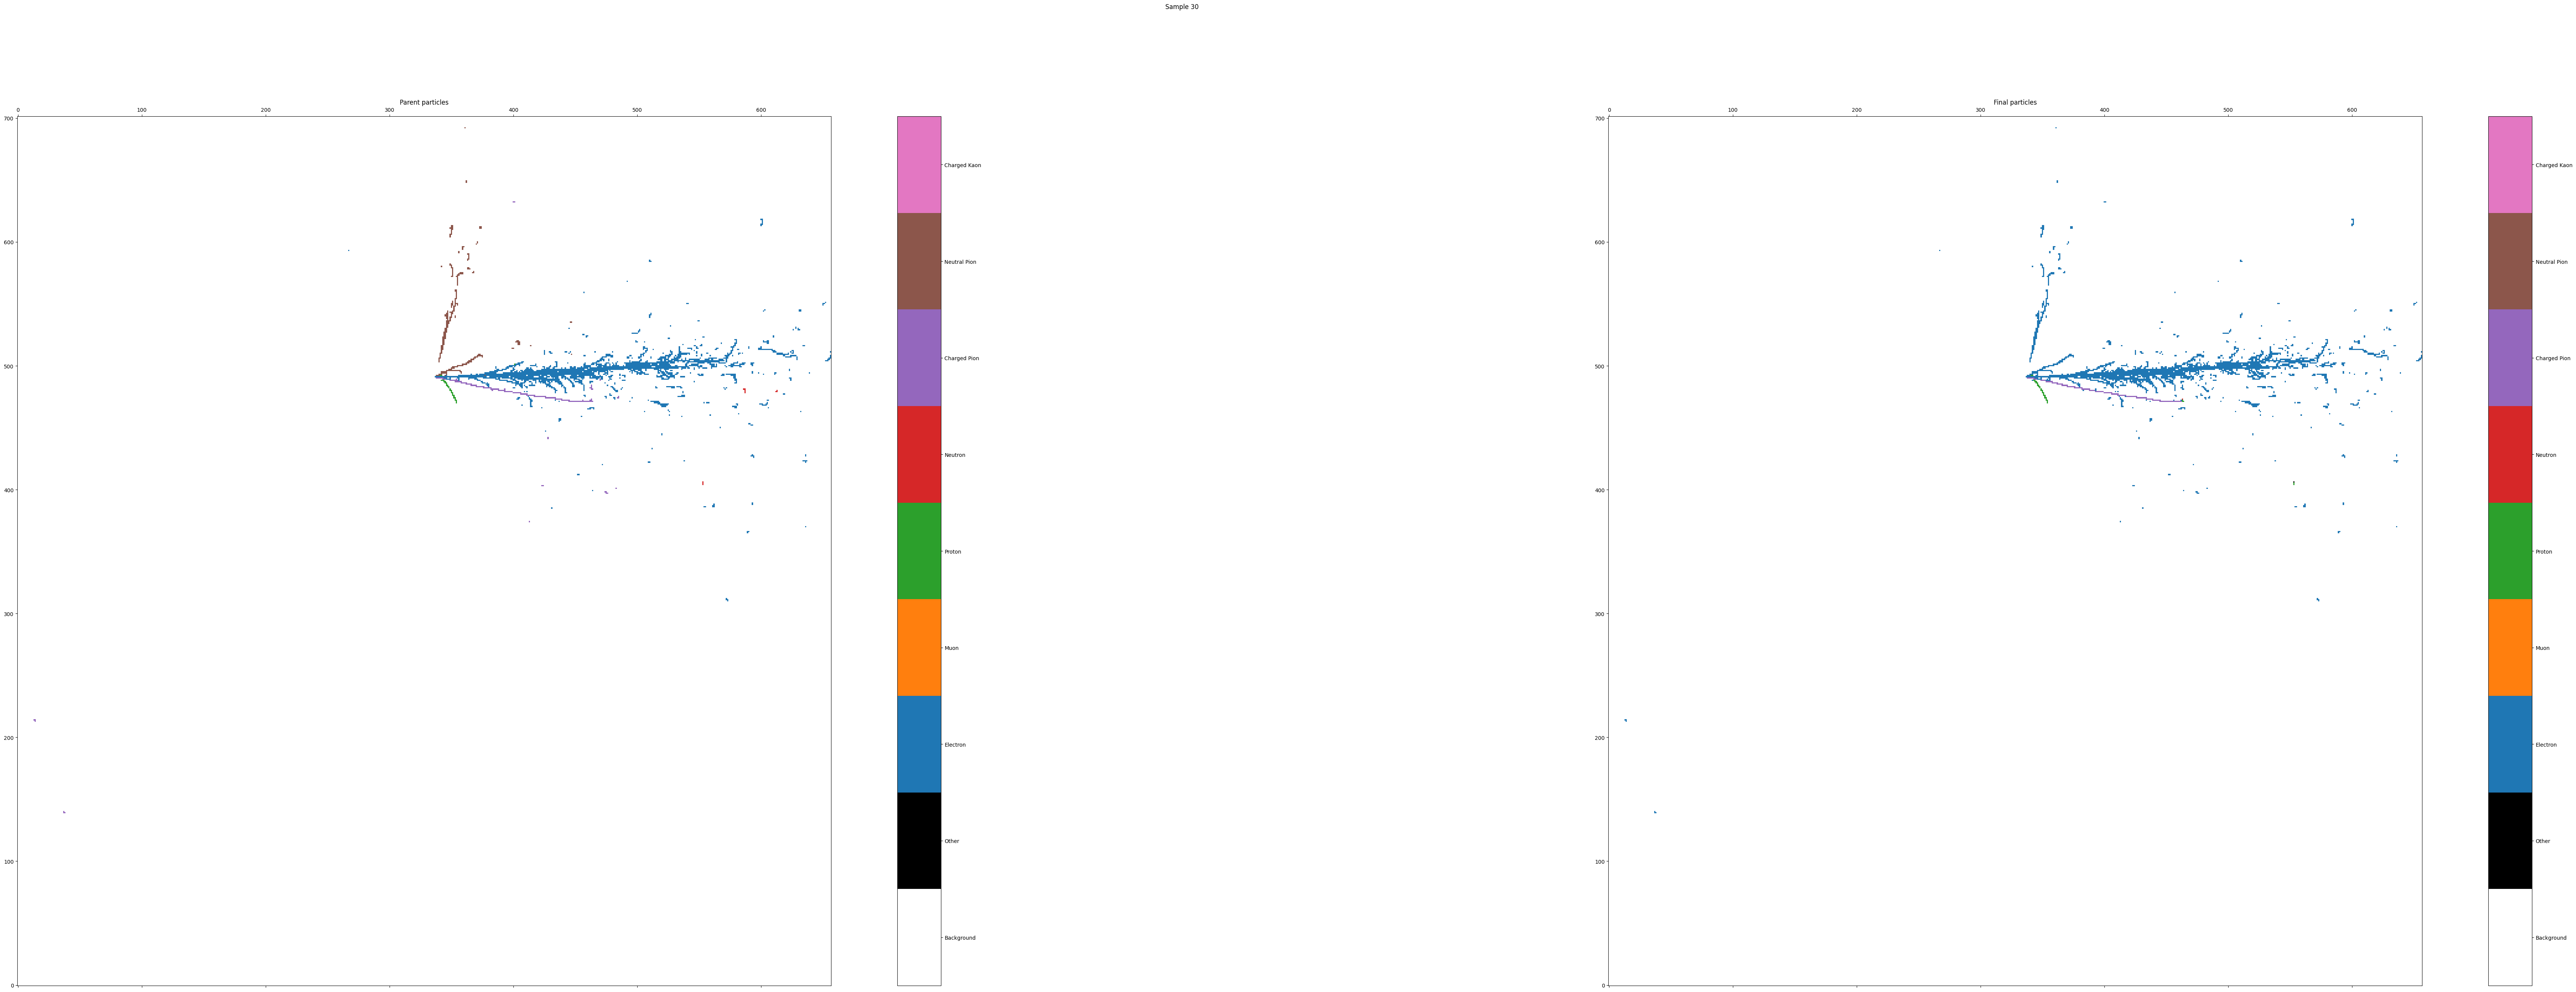

In [7]:
plot_sample(30)

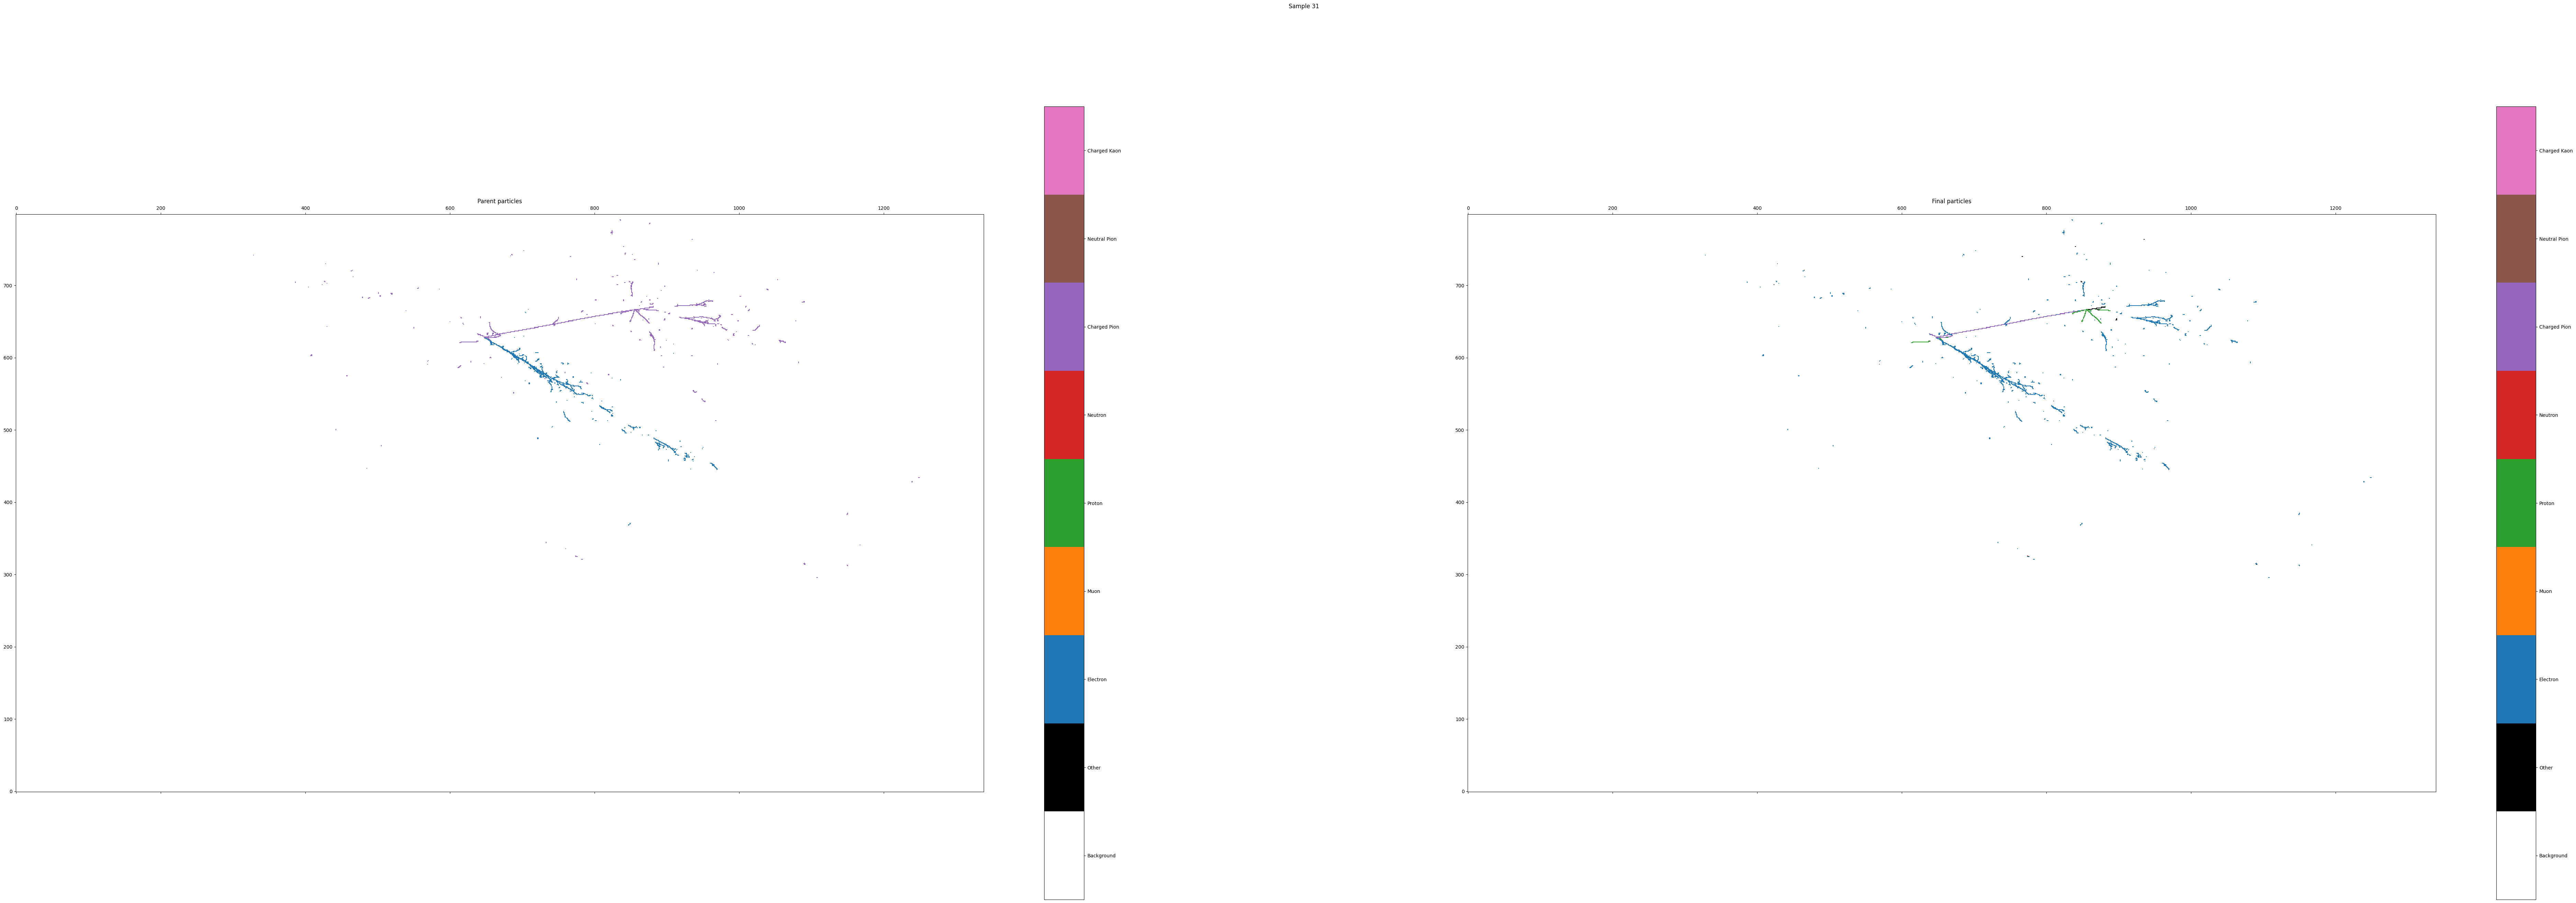

In [8]:
plot_sample(31)

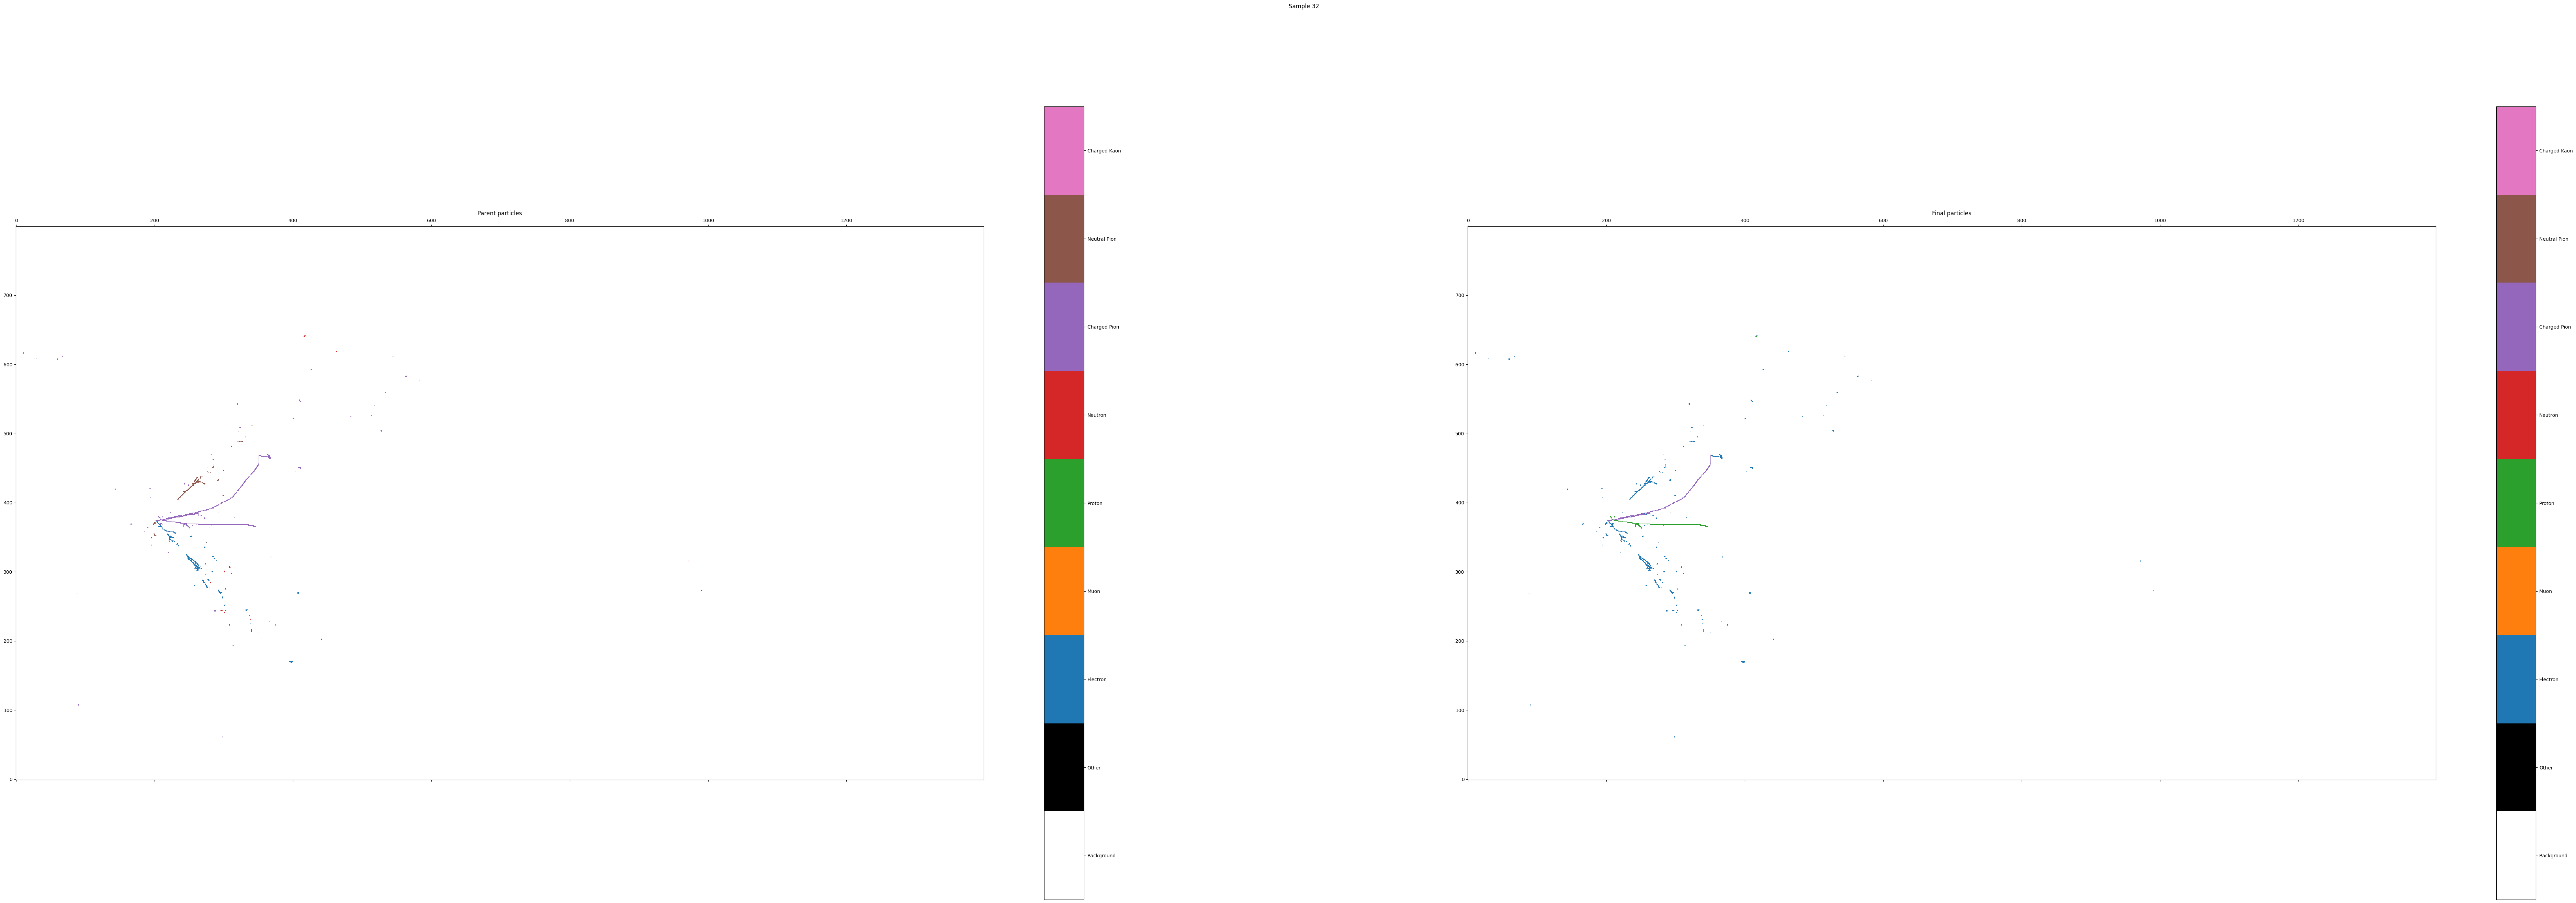

In [9]:
plot_sample(32)

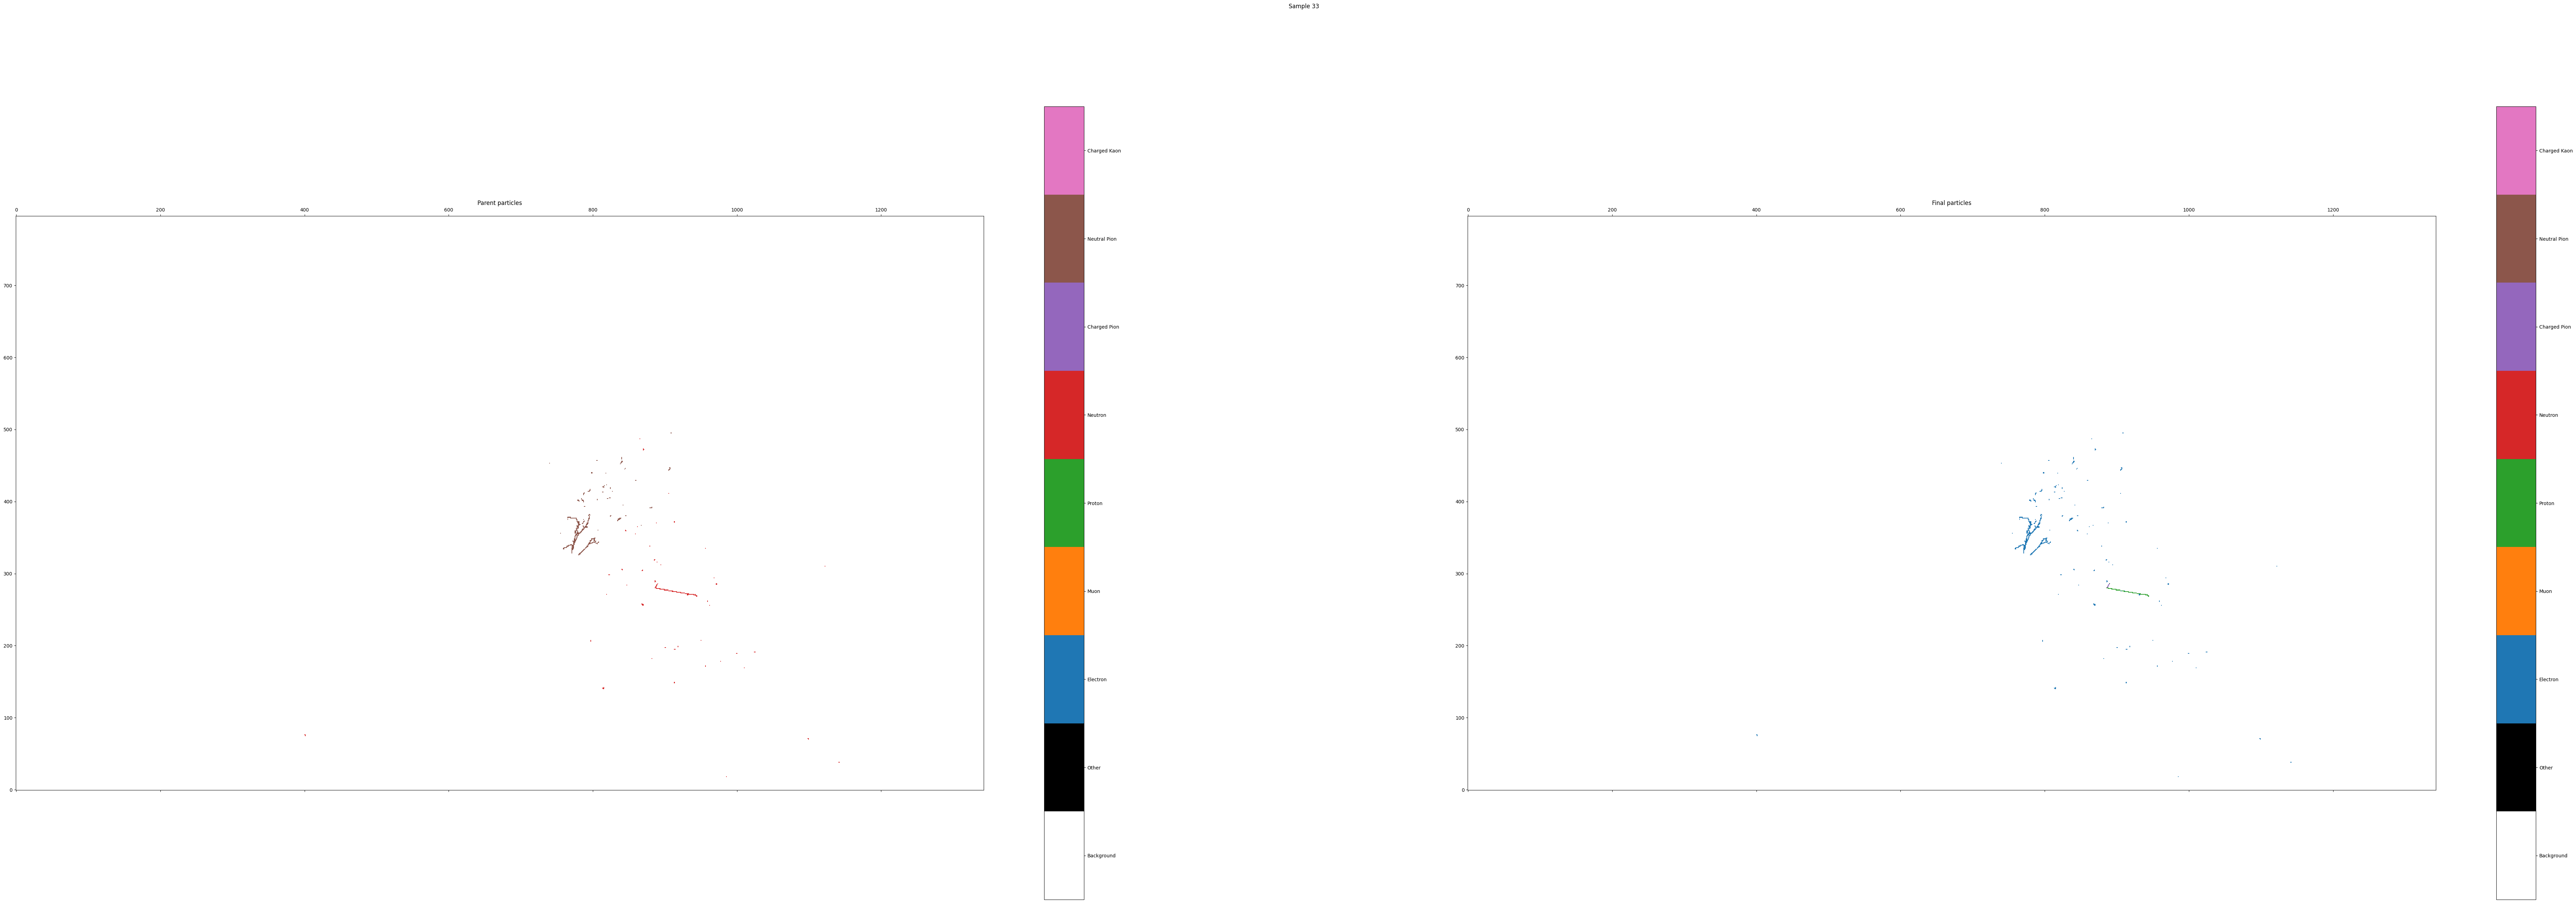

In [10]:
plot_sample(33)

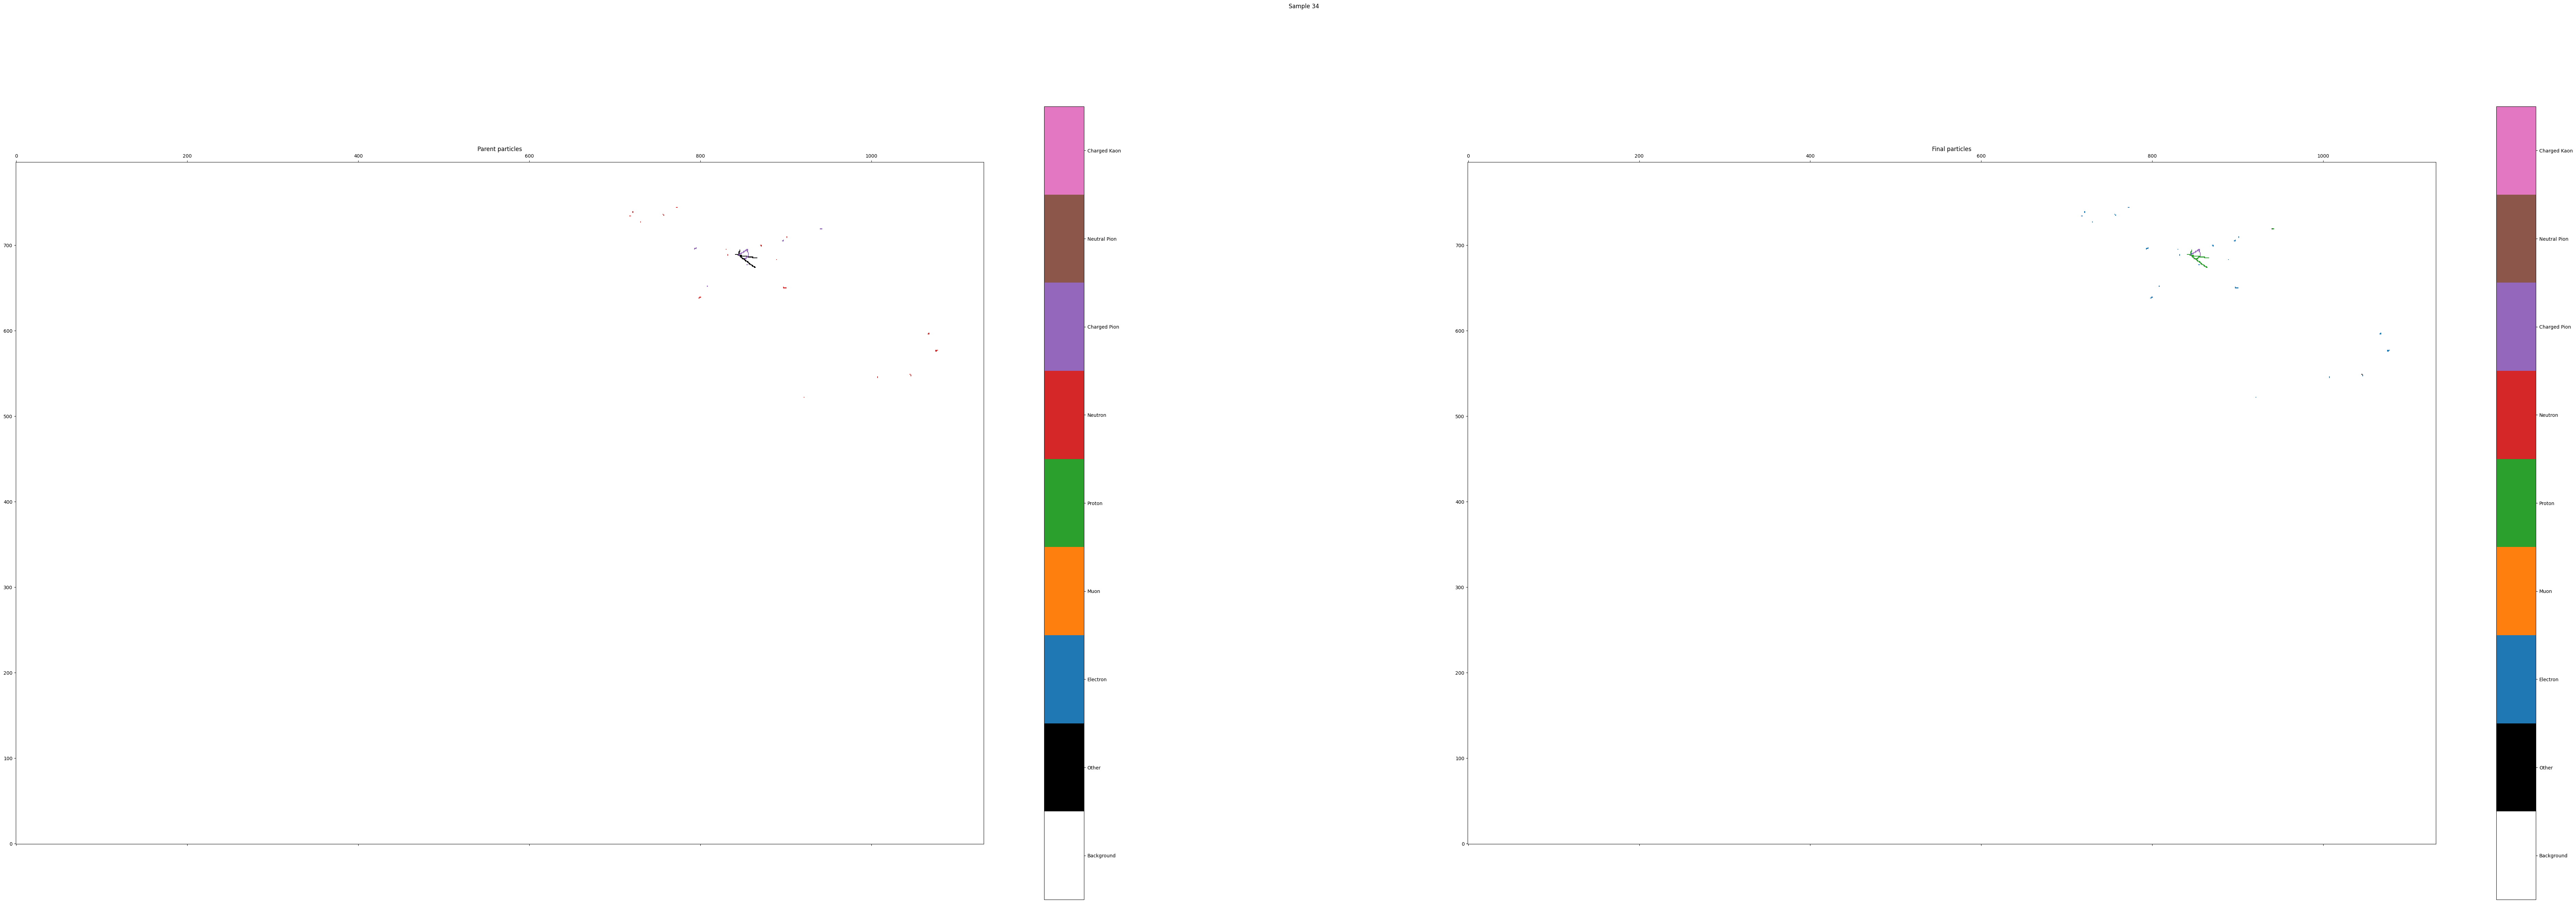

In [11]:
plot_sample(34)

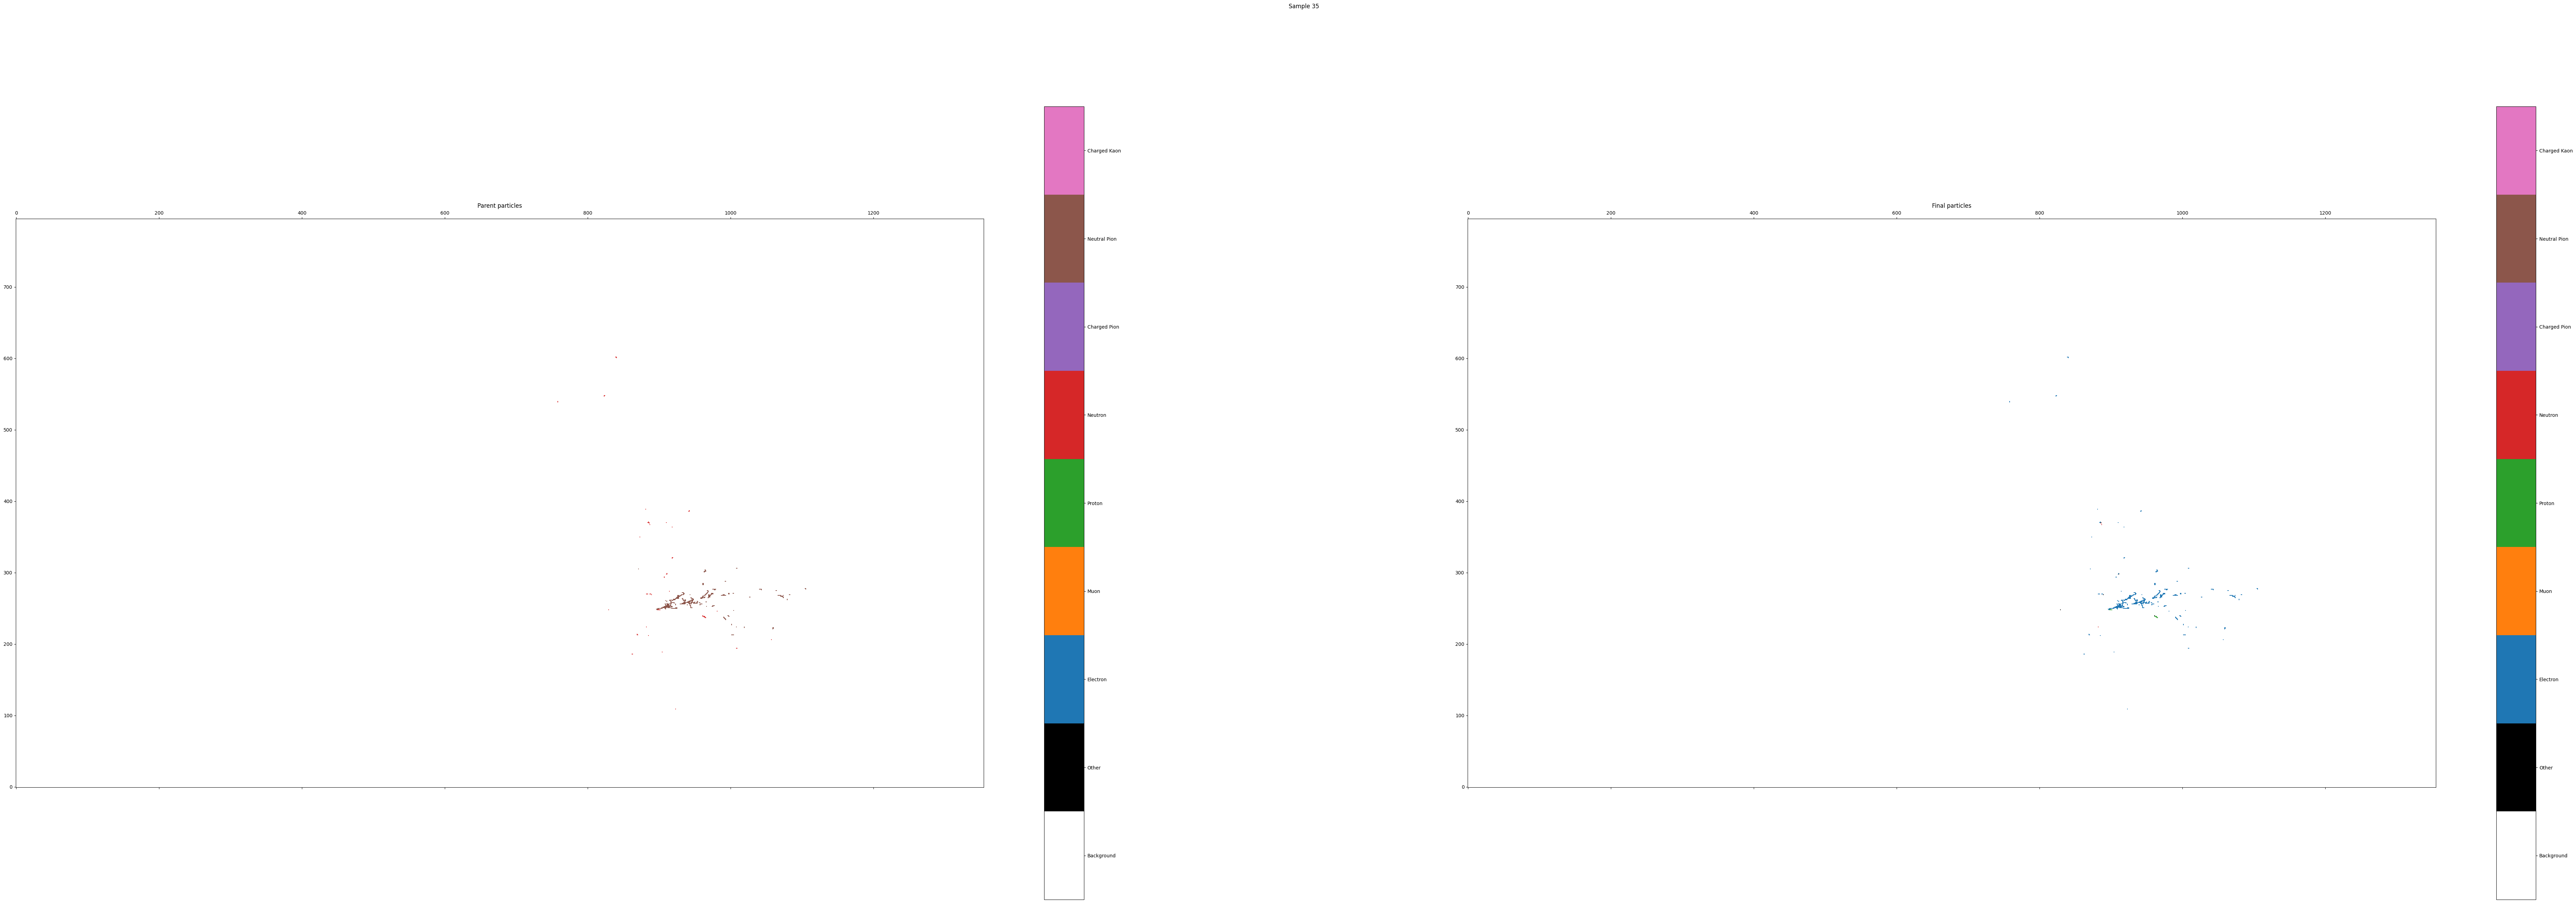

In [12]:
plot_sample(35)

In [10]:
data_file = numu_files[12]
with h5py.File(data_file, 'r') as file:
    pdgs = np.abs(file["g4_data_0"]["pdg"][:])
    cross_comp = np.abs(file["g4_data_0"]["pdg"][:]) == np.expand_dims(class_ids, axis=0)
    mask = cross_comp.any(axis=1)
    classes = cross_comp.argmax(axis=1)

    coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
    evtid = file["g4_data_0"]["evtid"][:,0]
    pid = file["g4_data_0"]["pid"][:,0]
    prongs = file["g4_data_0"]["tid"][:,0]
    edep = file["g4_data_0"]["step_edep"][:,0]
    t = file["g4_data_0"]["step_no"][:,0]
    trueclasses = classes.copy()

    if True:
        for i in range(evtid.max() + 1):
            mask = evtid == i

            parents = np.zeros((np.unique(prongs[mask]).max()+1,))
            parents[prongs[mask]] = pid[mask]

            #print(np.unique(classes[mask][parents[prongs[mask]] == 0]))
            #print(np.unique(pdgs[mask][parents[prongs[mask]] == 0]))
            
            parentclasses = np.zeros((np.unique(prongs[mask]).max()+1,))
            parentclasses[prongs[mask]] = classes[mask]

            parents = parents.astype(int)
            parentclasses = parentclasses.astype(int)

            recursiveparent = parents.copy()

            while not (parents[recursiveparent] == 0).all():
                # take a step
                step = parents[recursiveparent]
                
                # only save when parent isn't a primary node
                stepmask = step != 0
                recursiveparent[stepmask] = step[stepmask]
            
            primary_prongs = np.unique(recursiveparent)


            # remove primary prongs
            mask[mask] =  ~np.isin(prongs[mask], primary_prongs)

            prongs[mask] = recursiveparent[prongs[mask]]
            
            classes[mask] = parentclasses[prongs[mask]]

            # relabel the prongs so that they're in a normal range
            _, prongs[evtid == i] = np.unique(prongs[evtid == i], return_inverse=True)

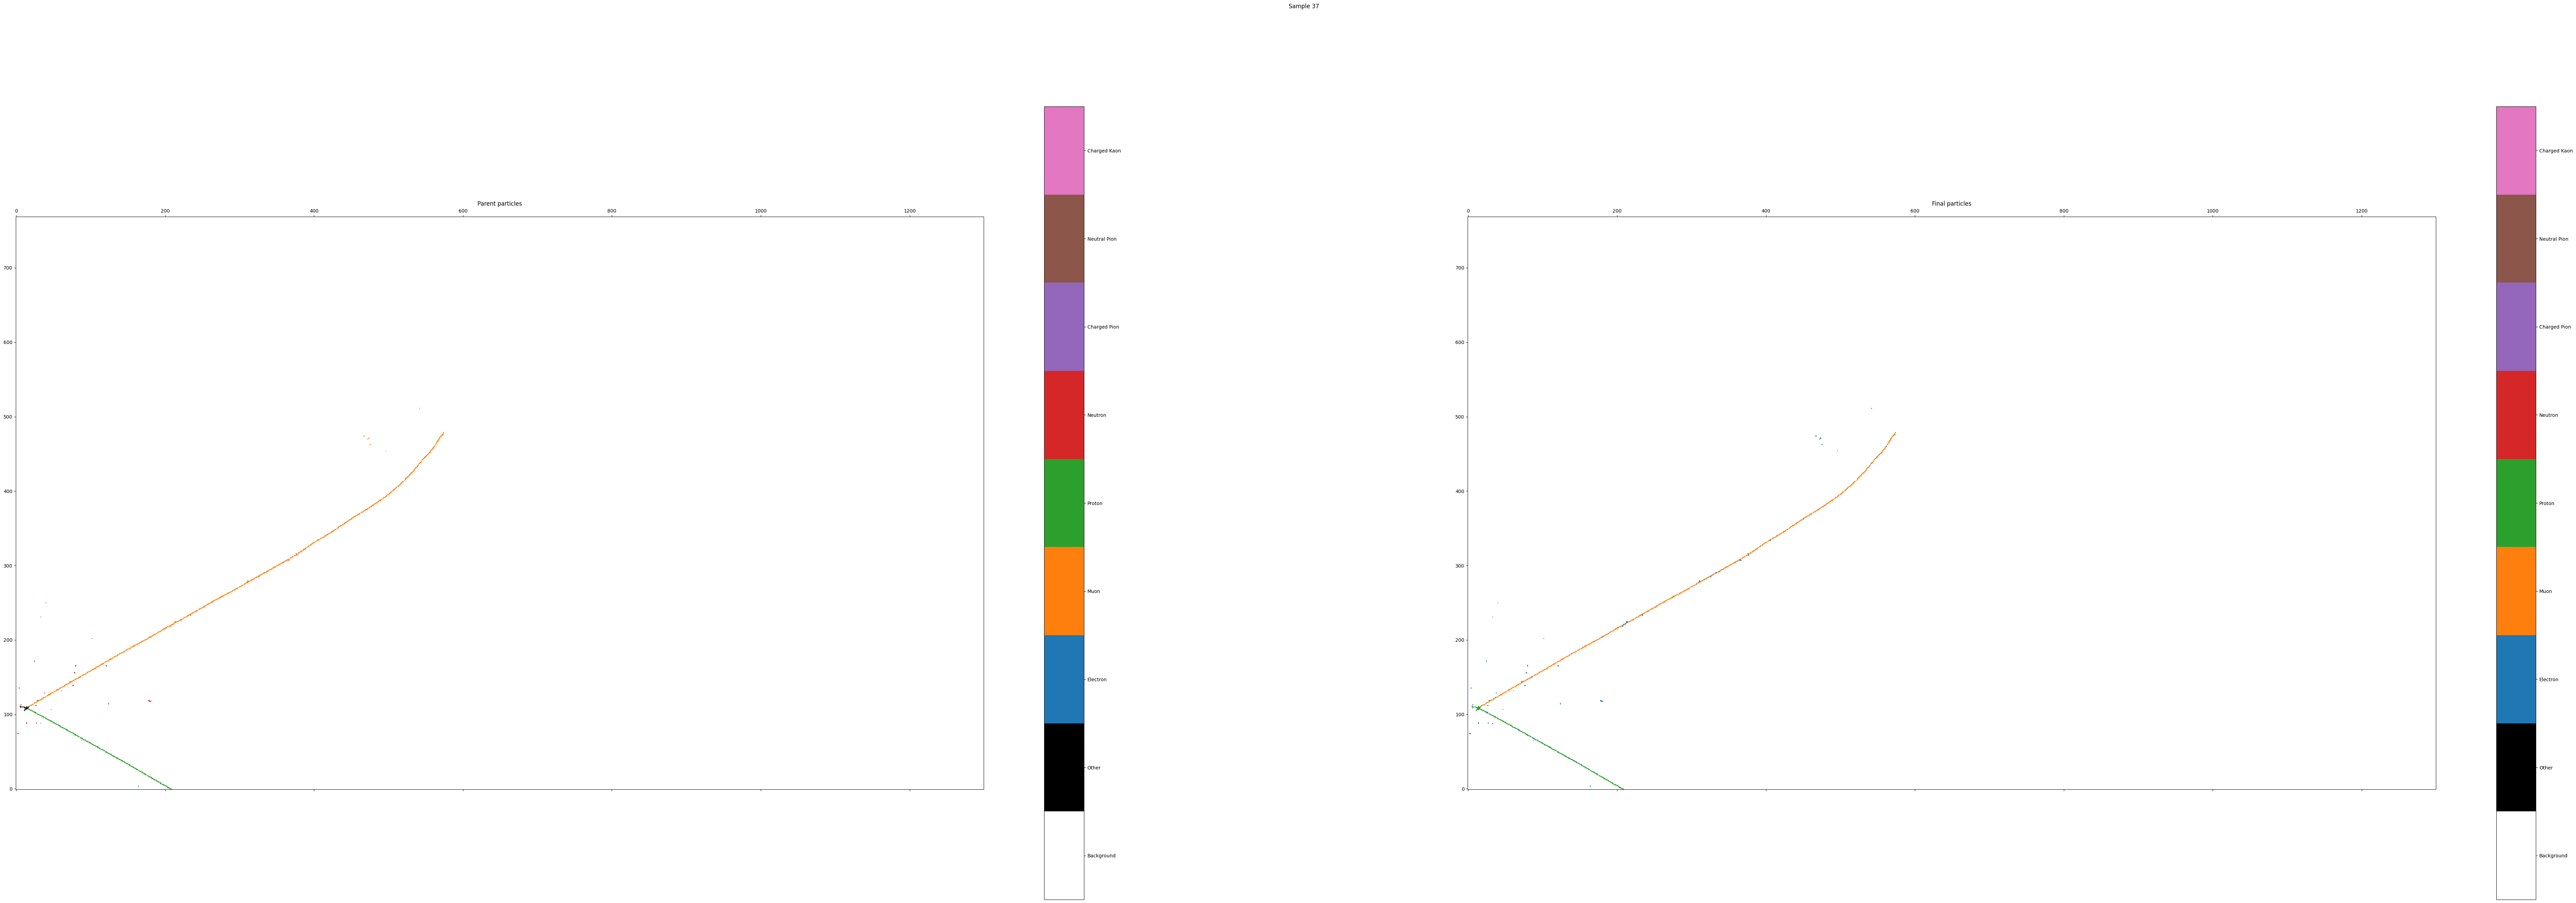

In [11]:
plot_sample(37)

In [26]:
data_file = numu_files[int(len(numu_files)*0.85) + 4]
with h5py.File(data_file, 'r') as file:
    pdgs = np.abs(file["g4_data_0"]["pdg"][:])
    cross_comp = np.abs(file["g4_data_0"]["pdg"][:]) == np.expand_dims(class_ids, axis=0)
    mask = cross_comp.any(axis=1)
    classes = cross_comp.argmax(axis=1)

    coords = np.stack([file["g4_data_0"]["step_x"][:,0], file["g4_data_0"]["step_y"][:,0], file["g4_data_0"]["step_z"][:,0]], axis=-1)
    evtid = file["g4_data_0"]["evtid"][:,0]
    pid = file["g4_data_0"]["pid"][:,0]
    prongs = file["g4_data_0"]["tid"][:,0]
    edep = file["g4_data_0"]["step_edep"][:,0]
    t = file["g4_data_0"]["step_no"][:,0]
    trueclasses = classes.copy()

    if True:
        for i in range(evtid.max() + 1):
            mask = evtid == i

            parents = np.zeros((np.unique(prongs[mask]).max()+1,))
            parents[prongs[mask]] = pid[mask]

            #print(np.unique(classes[mask][parents[prongs[mask]] == 0]))
            #print(np.unique(pdgs[mask][parents[prongs[mask]] == 0]))
            
            parentclasses = np.zeros((np.unique(prongs[mask]).max()+1,))
            parentclasses[prongs[mask]] = classes[mask]

            parents = parents.astype(int)
            parentclasses = parentclasses.astype(int)

            recursiveparent = parents.copy()

            while not (parents[recursiveparent] == 0).all():
                # take a step
                step = parents[recursiveparent]
                
                # only save when parent isn't a primary node
                stepmask = step != 0
                recursiveparent[stepmask] = step[stepmask]
            
            primary_prongs = np.unique(recursiveparent)


            # remove primary prongs
            mask[mask] =  ~np.isin(prongs[mask], primary_prongs)

            prongs[mask] = recursiveparent[prongs[mask]]
            
            classes[mask] = parentclasses[prongs[mask]]

            # relabel the prongs so that they're in a normal range
            _, prongs[evtid == i] = np.unique(prongs[evtid == i], return_inverse=True)

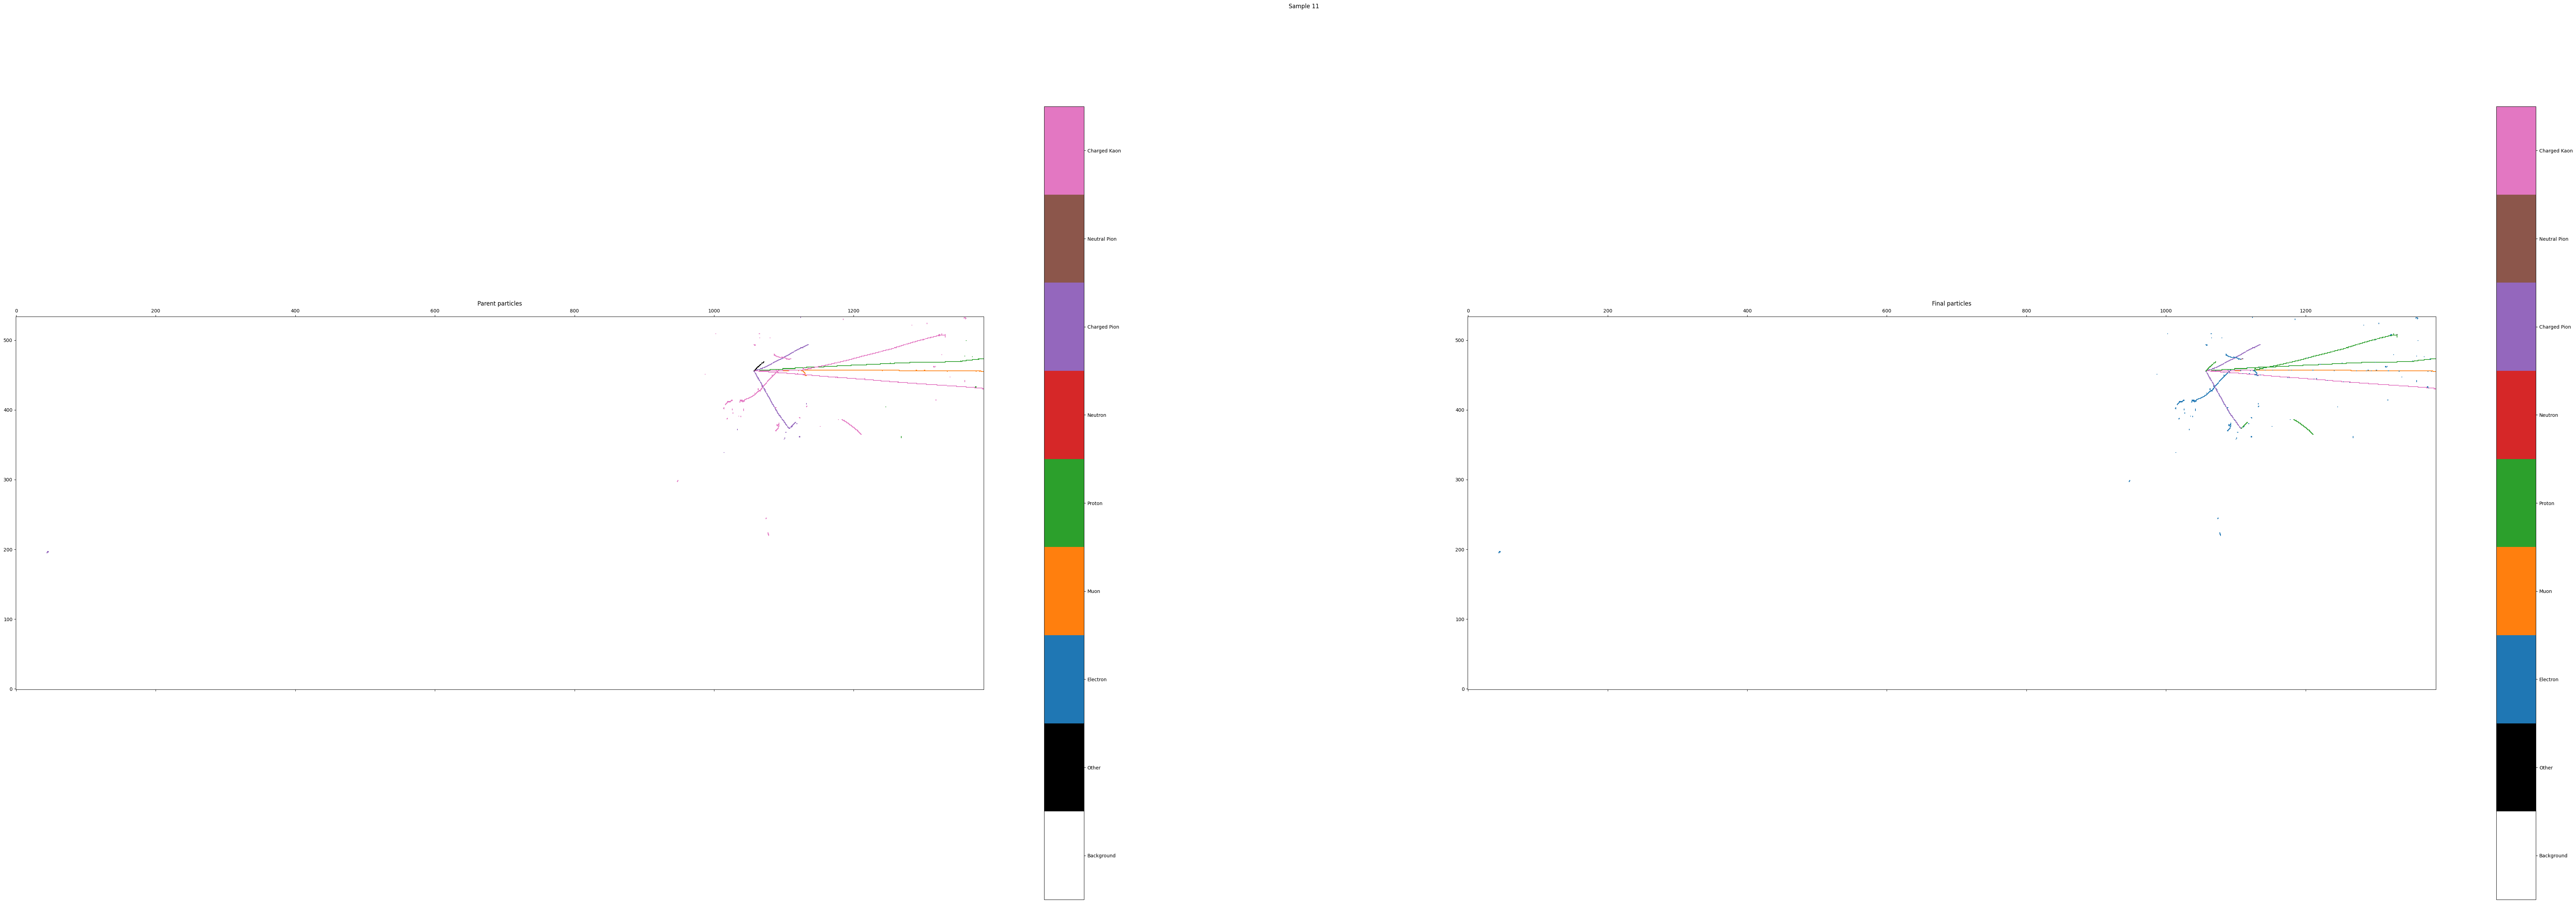

In [27]:
plot_sample(11)

In [29]:
kaonids = [46, 30,  3, 21, 35, 12, 39,  5, 10, 12, 13, 23, 43, 13, 37,  1,  2, 17,
        31, 34,  4, 17,  2, 33, 34, 22,  8, 38, 18,  7, 12, 36,  6, 34,  8, 32,
        45, 28, 32, 37,  8,  7, 10, 11, 48, 14, 26, 36, 49,  0, 19, 28, 24, 26,
        25, 39, 46,  6,  2, 23, 38, 12, 19, 22, 37,  5, 20, 27, 16, 45,  8, 48,
        17, 38, 30, 44, 19, 10, 35,  8, 42, 32,  5,  9, 19, 15, 32, 19, 12,  5,
        42, 48, 41, 20, 38, 42, 49, 14, 43, 31, 15,  9, 47, 30, 19,  3,  2,  6,
        25, 45, 38, 18, 37, 40, 25, 37, 23,  6, 46, 13, 49, 12, 34, 43, 29,  0,
         8, 48, 26,  3, 16,  4, 39, 49, 17, 19, 10, 13, 27, 30, 11, 27, 28,  6,
        31, 43, 48,  9, 37, 10, 32, 42, 31, 14, 32, 41,  7, 13, 37, 17, 18, 15,
        13, 30,  3, 16, 12, 17, 40, 25, 26, 27,  6, 15, 34, 27,  5,  9, 18, 40,
        42,  7, 12, 23, 44, 31, 43, 46,  7, 30, 40, 11, 44, 21,  4,  7, 25, 40,
        49,  6,  6, 15,  3, 19, 33,  7, 42, 47, 16, 33, 49, 24, 28, 41, 47, 13,
        40, 46, 47,  1,  6, 32,  1, 49, 15, 35, 40, 42,  7, 29, 13, 42, 14, 15,
        41,  3,  0,  9, 37,  1, 28, 43, 36, 21, 21,  2, 47, 34, 48,  8, 38, 48,
         7, 12, 28, 37, 17, 27, 40, 43,  8, 30, 20, 17, 26,  6,  4, 16, 27, 14,
        40, 48, 20,  7, 22,  0, 27,  7,  0, 21, 23, 34, 25, 25, 29, 45, 49,  2,
        41, 17, 15, 11, 29, 12, 45, 32, 17, 29, 49, 18, 26, 46, 15,  6, 36, 37,
        37, 27, 47,  3, 18,  0, 13, 24, 49, 32, 10, 22, 40, 27,  2, 14, 29, 24,
        49, 38, 42,  6,  8,  4,  7, 14, 17,  3, 37, 47,  3, 16, 19, 13, 21, 38,
        28, 10, 22, 12, 37, 41, 25, 34, 29, 46, 28,  7, 29,  5,  6,  7, 46, 21,
        25, 20,  8, 15,  5, 18, 24, 18, 40,  2, 17, 48,  1,  7, 10, 43,  3, 21,
        17, 24,  6, 14, 31, 36, 47, 38,  9, 45,  2, 45, 13, 17, 49,  9, 32, 38,
        43, 46, 25, 31, 48, 49,  4,  5, 21, 41, 43, 30,  0, 38, 37, 44, 36, 23,
        25, 28, 49,  8, 43, 30, 35,  8, 39,  0, 38, 11, 47, 44, 30, 20, 18, 45,
        36, 21, 29,  1,  3,  7, 15, 22, 39, 47,  9, 11, 44, 42, 11, 40, 13, 21,
        34, 39, 46,  2,  0,  1, 10, 41, 17, 33, 25, 22, 43, 46, 30, 11,  2, 13,
        21, 23, 10,  5, 22,  9, 31,  4, 42, 28, 37, 14, 41, 36,  1, 15,  3, 13,
        40, 27, 40, 29, 38, 24, 10, 14, 26, 42, 24, 21, 23, 27, 29, 34, 41, 47,
         4, 18, 23]

kaonfiles = [  0,   1,   3,   3,   3,   4,   4,   6,   6,   6,   6,   6,   7,  11,
         13,  14,  15,  17,  17,  18,  19,  19,  24,  25,  25,  26,  27,  27,
         28,  29,  29,  29,  30,  31,  33,  34,  34,  35,  35,  37,  39,  42,
         42,  42,  43,  44,  46,  46,  48,  48,  49,  49,  50,  50,  51,  51,
         52,  53,  54,  54,  54,  55,  55,  56,  57,  58,  60,  60,  61,  61,
         62,  62,  64,  64,  65,  65,  66,  67,  68,  69,  70,  72,  77,  78,
         78,  83,  83,  84,  85,  86,  86,  86,  89,  90,  92,  93,  94,  94,
         94,  95,  96,  97,  97,  98,  99, 100, 101, 101, 102, 102, 103, 104,
        104, 105, 106, 106, 107, 109, 109, 110, 113, 114, 114, 114, 116, 118,
        118, 124, 125, 126, 126, 127, 127, 128, 128, 128, 129, 129, 129, 129,
        130, 130, 130, 131, 131, 131, 132, 133, 134, 137, 140, 140, 142, 143,
        143, 143, 144, 144, 144, 145, 145, 147, 148, 149, 150, 150, 151, 151,
        151, 152, 152, 153, 155, 155, 156, 157, 158, 159, 160, 160, 160, 163,
        163, 163, 163, 164, 164, 164, 165, 166, 168, 171, 171, 172, 173, 177,
        178, 179, 180, 180, 181, 181, 182, 182, 182, 184, 184, 185, 188, 188,
        189, 190, 191, 191, 191, 192, 192, 193, 193, 194, 194, 194, 195, 196,
        196, 196, 196, 196, 197, 197, 198, 198, 200, 200, 200, 202, 203, 204,
        204, 205, 206, 206, 207, 209, 211, 212, 213, 214, 217, 219, 221, 221,
        222, 224, 225, 225, 226, 226, 226, 227, 228, 229, 231, 234, 234, 235,
        237, 237, 237, 239, 239, 239, 240, 241, 241, 244, 244, 246, 247, 247,
        247, 247, 248, 252, 255, 255, 256, 256, 257, 258, 260, 262, 263, 264,
        264, 265, 266, 266, 268, 268, 268, 268, 275, 277, 277, 277, 279, 281,
        281, 282, 282, 283, 285, 285, 286, 286, 287, 287, 287, 288, 289, 289,
        289, 290, 291, 291, 294, 296, 296, 297, 297, 298, 298, 299, 300, 300,
        301, 301, 301, 302, 302, 306, 309, 311, 311, 315, 316, 316, 317, 317,
        318, 318, 321, 322, 325, 326, 326, 326, 326, 327, 327, 330, 332, 333,
        336, 336, 336, 337, 337, 339, 340, 341, 342, 342, 342, 343, 344, 344,
        345, 346, 347, 347, 347, 347, 348, 350, 351, 351, 352, 352, 354, 356,
        357, 358, 358, 360, 360, 360, 362, 362, 362, 364, 365, 366, 366, 367,
        367, 368, 370, 370, 371, 372, 374, 375, 375, 377, 378, 378, 378, 381,
        382, 387, 387, 388, 390, 396, 397, 399, 400, 403, 405, 405, 406, 407,
        408, 409, 410, 410, 410, 410, 410, 410, 411, 411, 411, 412, 413, 414,
        415, 416, 416, 417, 418, 420, 421, 421, 422, 425, 426, 426, 428, 429,
        430, 430, 431, 432, 433, 433, 434, 434, 435, 436, 438, 439, 439, 440,
        440, 442, 442, 444, 444, 445, 446, 451, 452, 452, 452, 453, 453, 454,
        455, 456, 457, 458, 458, 458, 459, 460, 460, 460, 461, 461, 462, 463,
        466, 467, 469]

In [148]:
np.unique(pid), pid.shape

(array([   0,    1,    2, ..., 9061, 9063, 9064], dtype=int32), (62489,))

In [149]:
np.unique(prongs_og), prongs_og.shape

(array([   1,    2,    3, ..., 4942, 4943, 4944], dtype=int32), (46982,))

In [261]:
numu_files[int(len(numu_files)*0.85) + 19]

PosixPath('/home/roblesee/dune/hpst/data/sim_data/train/argon_cubic_production/argon_cubic_numu_production_1952.h5')

In [255]:
distribution = []
for id_, file in tqdm(zip(kaonids, kaonfiles)):
    if id_ == 0:
        id_ = 50
        file = file - 1
    id_ -= 1
    data_file = numu_files[int(len(numu_files)*0.85) + file]
    with h5py.File(data_file, 'r') as file:
        evtid = file["g4_data_0"]["evtid"][:,0]
        mask = evtid == id_
        diff = np.where(np.diff(mask))[0]
        diff[0] += 1
        if id_ == 0:
            diff = (0, diff[0])
            print(evtid[diff[0]:diff[1]])
        elif id_ == 49:
            diff = (diff[0], -1)
            print(evtid[diff[0]:diff[1]])
        
        pdgs = np.abs(file["g4_data_0"]["pdg"][diff[0]:diff[1]])
        cross_comp = np.abs(file["g4_data_0"]["pdg"][diff[0]:diff[1]]) == np.expand_dims(class_ids, axis=0)
        mask = cross_comp.any(axis=1)
        classes = cross_comp.argmax(axis=1)
    
        coords = np.stack([file["g4_data_0"]["step_x"][diff[0]:diff[1],0], file["g4_data_0"]["step_y"][diff[0]:diff[1],0], file["g4_data_0"]["step_z"][diff[0]:diff[1],0]], axis=-1)
        evtid = file["g4_data_0"]["evtid"][diff[0]:diff[1],0]
        pid = file["g4_data_0"]["pid"][diff[0]:diff[1],0]
        prongs = file["g4_data_0"]["tid"][diff[0]:diff[1],0]
        edep = file["g4_data_0"]["step_edep"][diff[0]:diff[1],0]
        t = file["g4_data_0"]["step_no"][diff[0]:diff[1],0]
        prongs_og = file["g4_data_0"]["tid"][diff[0]:diff[1],0].copy()
        trueclasses = classes.copy()
    
        if True:
            for i in [evtid.max()]:
                mask = evtid == i
    
                parents = np.zeros((np.unique(prongs[mask]).max()+1,))
                parents[prongs[mask]] = pid[mask]
    
                #print(np.unique(classes[mask][parents[prongs[mask]] == 0]))
                #print(np.unique(pdgs[mask][parents[prongs[mask]] == 0]))
                
                parentclasses = np.zeros((np.unique(prongs[mask]).max()+1,))
                parentclasses[prongs[mask]] = classes[mask]
    
                parents = parents.astype(int)
                parentclasses = parentclasses.astype(int)
    
                recursiveparent = parents.copy()
    
                while not (parents[recursiveparent] == 0).all():
                    # take a step
                    step = parents[recursiveparent]
                    
                    # only save when parent isn't a primary node
                    stepmask = step != 0
                    recursiveparent[stepmask] = step[stepmask]
                
                primary_prongs = np.unique(recursiveparent)
    
    
                # remove primary prongs
                mask[mask] =  ~np.isin(prongs[mask], primary_prongs)
    
                prongs[mask] = recursiveparent[prongs[mask]]
                
                classes[mask] = parentclasses[prongs[mask]]
    
                # relabel the prongs so that they're in a normal range
                _, prongs[evtid == i] = np.unique(prongs[evtid == i], return_inverse=True)
        #print(np.unique(classes))
        mask = evtid == i
        prongs[mask]
        if (trueclasses[mask][classes[mask] == 7] == 1).any():
            parents = np.zeros((np.unique(prongs_og[mask]).max()+1,), dtype=trueclasses.dtype)
            parents[prongs_og[mask]] = pid[mask]
            parentclasses = np.zeros((np.unique(prongs_og[mask]).max()+1,), dtype=trueclasses.dtype)
            parentclasses[prongs_og[mask]] = trueclasses[mask]
            parentpdgs = np.zeros((np.unique(prongs_og[mask]).max()+1,), dtype=trueclasses.dtype)
            parentpdgs[prongs_og[mask]] = pdgs[mask,0]

            finalprongs = ~np.isin(prongs_og, parents)
            finalprongs = np.unique(prongs_og[finalprongs])
            firstout = []
            for pid in finalprongs:
                classes = [parentclasses[pid]]
                pids = [pid]
                while parents[pid] != 0:
                    classes.append(parentclasses[pid])
                    pid = parents[pid]
                    pids.append(pid)
                if classes[-1] == 7:
                    firstout.append(parentpdgs[pids[-3]])
                    #print(classes[-2:], [parentpdgs[p] for p in pids[-3:-1]])
            print(np.unique(firstout))
            
            #mask = (trueclasses == 1) & (classes == 7)
            #mask = classes == 7
            #print(prongs_og[mask])
            #print(np.unique(pdgs[mask]))
            #print(np.unique(parentpdgs[prongs_og[mask]]))
            #print(np.unique(parentpdgs[parents[prongs_og[mask]]]))
            #print(np.unique(parentpdgs[parents[parents[prongs_og[mask]]]]))
            #print(np.unique(parentpdgs[parents[parents[parents[prongs_og[mask]]]]]))
            
            #print(classes[mask])
            #print(trueclasses[mask])
            #print(np.unique(parentpdgs[prongs_og[mask]]))
            #print(np.unique(parentclasses[prongs_og[mask]]))
            #print(np.unique(parentpdgs[parents[parents[prongs_og[mask]]]]))
            
            #print(parentclasses[prongs_og[mask]][0],parentclasses[parents[prongs_og[mask]]][0],parentclasses[parents[parents[prongs_og[mask]]]][0],parentclasses[parents[parents[parents[prongs_og[mask]]]]][0])
            #print(parentpdgs[prongs_og[mask]][0],parentpdgs[parents[prongs_og[mask]]][0],parentpdgs[parents[parents[prongs_og[mask]]]][0],parentpdgs[parents[parents[parents[prongs_og[mask]]]]][0])
            #print(parentclasses[parents[parents[prongs_og[mask]]]])
            #print(parentclasses[parents[parents[parents[prongs_og[mask]]]]])
            #print(classes[mask][0])
            #print(trueclasses[mask][0])
            

        distribution.append(trueclasses[classes == 7])

1it [00:00,  2.72it/s]

[]


2it [00:00,  2.83it/s]

[13 14]


3it [00:01,  2.73it/s]

[        11         22        130       2112 1000170370]


4it [00:01,  2.56it/s]

[13 14]


5it [00:01,  2.57it/s]

[]


6it [00:02,  2.75it/s]

[]


7it [00:02,  2.80it/s]

[]


8it [00:03,  2.54it/s]

[        11         22        321       2112       2212 1000170370]


9it [00:03,  2.49it/s]

[        11         22        321       2112 1000180390]


10it [00:03,  2.42it/s]

[11 13 14]


11it [00:04,  2.36it/s]

[111 211]


12it [00:04,  2.47it/s]

[]


13it [00:05,  2.41it/s]

[        11         22       2112       2212       3112 1000010020
 1000100220]


14it [00:05,  2.53it/s]

[]


15it [00:05,  2.41it/s]

[        11         22        111        321       2112       2212
 1000140290]


16it [00:06,  2.59it/s]

[0 0 0 ... 0 0 0]
[]


17it [00:06,  2.77it/s]

[]


18it [00:07,  2.54it/s]

[        11         22        321       2112       2212 1000020030
 1000140300]


19it [00:07,  2.30it/s]

[]


20it [00:07,  2.42it/s]

[]


21it [00:08,  2.60it/s]

[]


22it [00:08,  2.79it/s]

[]


23it [00:08,  2.74it/s]

[]


24it [00:09,  2.78it/s]

[11]


25it [00:09,  2.86it/s]

[ 11 111 211]


26it [00:09,  2.97it/s]

[11]


27it [00:10,  2.55it/s]

[211]


28it [00:10,  2.60it/s]

[]


29it [00:11,  2.47it/s]

[        11         22        310       2112       2212 1000010020
 1000140290]


30it [00:11,  2.45it/s]

[]


31it [00:12,  2.38it/s]

[        11         22        310       2112       2212 1000180380]


32it [00:12,  2.31it/s]

[        11         22        321       2112       2212 1000160350]


34it [00:13,  2.47it/s]

[111 211]


35it [00:13,  2.59it/s]

[]


36it [00:14,  2.59it/s]

[]


37it [00:14,  2.74it/s]

[13 14]


38it [00:14,  2.43it/s]

[]


39it [00:15,  2.38it/s]

[]


40it [00:15,  2.35it/s]

[13 14]


41it [00:16,  2.42it/s]

[]


42it [00:16,  2.34it/s]

[        11         22        321       2112       2212 1000170380]


43it [00:16,  2.48it/s]

[11 13 14]


44it [00:17,  2.55it/s]

[        11         22        321       2112       2212 1000160350]


45it [00:17,  2.46it/s]

[]


46it [00:18,  2.43it/s]

[        11         22        310       2112       2212 1000010020
 1000150310]


47it [00:18,  2.35it/s]

[        11         22        321       2112       2212 1000170370]


48it [00:18,  2.47it/s]

[]


50it [00:19,  2.54it/s]

[49 49 49 ... 49 49 49]
[        11         22        321       2112       2212 1000160350]


51it [00:20,  2.59it/s]

[]


52it [00:20,  2.57it/s]

[]


53it [00:20,  2.46it/s]

[13 14]


54it [00:21,  2.58it/s]

[]


55it [00:21,  2.94it/s]

[]


56it [00:21,  3.23it/s]

[]


57it [00:22,  2.89it/s]

[]


58it [00:22,  2.64it/s]

[]


59it [00:23,  2.46it/s]

[]


60it [00:23,  2.52it/s]

[]


61it [00:23,  2.67it/s]

[]


62it [00:24,  2.39it/s]

[        11         22        321       2112       2212 1000160350]


63it [00:24,  2.37it/s]

[ 11 211]


64it [00:25,  2.54it/s]

[]


65it [00:25,  2.38it/s]

[ 11 111 211]


66it [00:26,  2.30it/s]

[111 211]


67it [00:26,  2.54it/s]

[]


68it [00:26,  2.53it/s]

[13 14]


69it [00:27,  2.35it/s]

[11 13 14]


70it [00:27,  2.40it/s]

[]


71it [00:28,  2.37it/s]

[        11         22        211       2112 1000020040 1000150310]


72it [00:28,  2.45it/s]

[        22        321       2112       2212 1000010020 1000120240]


73it [00:28,  2.28it/s]

[]


74it [00:29,  2.16it/s]

[        11         22        111        211        321       2112
       2212 1000140290]


75it [00:29,  2.16it/s]

[]


76it [00:30,  2.30it/s]

[11]


77it [00:30,  2.36it/s]

[]


78it [00:31,  2.37it/s]

[]


79it [00:31,  2.12it/s]

[]


80it [00:32,  2.15it/s]

[11 13 14]


81it [00:32,  2.16it/s]

[]


82it [00:33,  2.21it/s]

[]


83it [00:33,  2.25it/s]

[]


84it [00:33,  2.37it/s]

[]


85it [00:34,  2.45it/s]

[        11         22        321       2112 1000180370]


86it [00:34,  2.57it/s]

[]


87it [00:34,  2.57it/s]

[13 14]


88it [00:35,  2.81it/s]

[]


89it [00:35,  2.65it/s]

[]


90it [00:36,  2.47it/s]

[]


91it [00:36,  2.48it/s]

[]


92it [00:36,  2.41it/s]

[]


93it [00:37,  2.29it/s]

[        11         22        321       2112       2212 1000160360]


94it [00:37,  2.47it/s]

[]


95it [00:38,  2.58it/s]

[]


96it [00:38,  2.69it/s]

[]


98it [00:39,  2.73it/s]

[]


99it [00:39,  2.87it/s]

[]


100it [00:39,  2.78it/s]

[]


101it [00:40,  2.60it/s]

[ 11 211]


102it [00:40,  2.66it/s]

[]


103it [00:41,  2.51it/s]

[13 14]


104it [00:41,  2.73it/s]

[]


105it [00:41,  2.58it/s]

[111 211]


106it [00:42,  2.43it/s]

[11 13 14]


107it [00:42,  2.46it/s]

[]


108it [00:43,  2.69it/s]

[        11         22        130       2112       2212 1000180380]


109it [00:43,  2.47it/s]

[]


110it [00:43,  2.56it/s]

[13 14]


111it [00:44,  2.68it/s]

[]


112it [00:44,  2.65it/s]

[]


113it [00:44,  2.64it/s]

[]


114it [00:45,  2.90it/s]

[]


115it [00:45,  2.53it/s]

[13 14]


116it [00:46,  2.64it/s]

[        11         22        321       2112 1000180390]


117it [00:46,  2.46it/s]

[]


118it [00:46,  2.61it/s]

[]


119it [00:47,  2.61it/s]

[13 14]


120it [00:47,  2.45it/s]

[]


122it [00:48,  2.45it/s]

[11]


123it [00:48,  2.58it/s]

[]


124it [00:49,  2.46it/s]

[13 14]


125it [00:49,  2.49it/s]

[]


126it [00:50,  2.57it/s]

[49 49 49 ... 49 49 49]
[13 14]


127it [00:50,  2.59it/s]

[]


128it [00:51,  2.27it/s]

[]


129it [00:51,  2.43it/s]

[        11         22        211        310       2112       2212
 1000010020 1000080160]


130it [00:51,  2.25it/s]

[]


131it [00:52,  2.34it/s]

[]


132it [00:52,  2.30it/s]

[]


133it [00:53,  2.45it/s]

[]


135it [00:53,  2.75it/s]

[        11         22        130       2112       2212 1000160360]


136it [00:54,  2.83it/s]

[]


137it [00:54,  2.86it/s]

[]


138it [00:54,  2.85it/s]

[        11         22        310       2112 1000170370]


139it [00:55,  2.94it/s]

[111 211]


140it [00:55,  2.94it/s]

[        11         22        130       2112       2212 1000020040
 1000130270]


141it [00:55,  2.68it/s]

[11]


142it [00:56,  2.60it/s]

[]


143it [00:56,  2.54it/s]

[        11         22        211        321       2112       2212
 1000010020 1000020030 1000020040 1000050100]


144it [00:57,  2.70it/s]

[        22        211        321       2112       2212 1000180380]


145it [00:57,  2.83it/s]

[13 14]


146it [00:57,  3.02it/s]

[]


147it [00:58,  2.83it/s]

[        11         22        111       2112       2212 1000010020
 1000140290]


148it [00:58,  2.62it/s]

[]


149it [00:58,  2.90it/s]

[]


150it [00:59,  2.67it/s]

[13 14]


151it [00:59,  2.56it/s]

[]


152it [01:00,  2.39it/s]

[]


153it [01:00,  2.51it/s]

[]


154it [01:00,  2.38it/s]

[        11         22        111        211        310       2112
       2212 1000140290]


155it [01:01,  2.41it/s]

[]


156it [01:01,  2.56it/s]

[        11         22        321       2112       2212 1000170370]


157it [01:01,  2.85it/s]

[]


158it [01:02,  3.12it/s]

[]


159it [01:02,  3.15it/s]

[]


160it [01:02,  2.88it/s]

[]


161it [01:03,  2.86it/s]

[]


162it [01:03,  3.09it/s]

[]


163it [01:03,  3.25it/s]

[211]


164it [01:04,  3.20it/s]

[]


165it [01:04,  3.07it/s]

[]


166it [01:04,  3.08it/s]

[]


167it [01:05,  3.07it/s]

[]


168it [01:05,  2.92it/s]

[]


169it [01:05,  2.76it/s]

[        11         22        130       2212 1000180390]


170it [01:06,  2.82it/s]

[11]


171it [01:06,  2.92it/s]

[        11         22        211       2112       2212 1000140300]


172it [01:06,  2.84it/s]

[]


173it [01:07,  2.49it/s]

[]


174it [01:07,  2.44it/s]

[]


175it [01:08,  2.55it/s]

[]


176it [01:08,  2.42it/s]

[]


177it [01:09,  2.48it/s]

[]


178it [01:09,  2.43it/s]

[]


179it [01:09,  2.43it/s]

[]


180it [01:10,  2.60it/s]

[]


181it [01:10,  2.72it/s]

[]


183it [01:11,  2.45it/s]

[]


184it [01:11,  2.45it/s]

[]


185it [01:12,  2.35it/s]

[]


186it [01:12,  2.46it/s]

[]


187it [01:13,  2.42it/s]

[]


188it [01:13,  2.42it/s]

[13 14]


189it [01:13,  2.38it/s]

[]


190it [01:14,  1.95it/s]

[]


191it [01:15,  2.00it/s]

[        11         22        211       2112       2212 1000010020
 1000150320]


192it [01:15,  2.11it/s]

[]


193it [01:15,  2.28it/s]

[ 11  12 111]


194it [01:16,  2.31it/s]

[]


195it [01:16,  2.49it/s]

[13 14]


196it [01:17,  2.26it/s]

[13 14]


197it [01:17,  2.50it/s]

[]


198it [01:17,  2.48it/s]

[        11         22        211       2112       2212 1000010020
 1000130270 1000180400]


200it [01:18,  2.45it/s]

[        11         22        111        211       2112       2212
 1000170360]


201it [01:19,  2.54it/s]

[]


202it [01:19,  2.59it/s]

[]


203it [01:19,  2.43it/s]

[]


204it [01:20,  2.51it/s]

[]


205it [01:20,  2.62it/s]

[        11         22        321       2112       2212 1000170380]


206it [01:21,  2.59it/s]

[        11        130       2112       2212 1000180360]


207it [01:21,  2.70it/s]

[]


208it [01:21,  2.65it/s]

[        11         22        130       2112 1000170390]


209it [01:22,  2.25it/s]

[        11         22        321       2112 1000180390]


210it [01:22,  2.27it/s]

[11 13 14]


212it [01:23,  2.26it/s]

[]


213it [01:24,  2.27it/s]

[        11         22        111        211       2112 1000180380]


214it [01:24,  2.42it/s]

[]


215it [01:24,  2.52it/s]

[        11         22        321       2112       2212 1000160350]


216it [01:25,  2.36it/s]

[]


217it [01:25,  2.73it/s]

[11]


218it [01:25,  2.67it/s]

[]


219it [01:26,  2.81it/s]

[]


220it [01:26,  2.91it/s]

[0 0 0 ... 0 0 0]
[111 211]


221it [01:26,  3.15it/s]

[]


222it [01:27,  3.37it/s]

[        11         22        321       2212 1000170390]


223it [01:27,  3.23it/s]

[0 0 0 ... 0 0 0]
[]


225it [01:27,  3.73it/s]

[        11         22        111       2112 1000010030 1000030060
 1000130270]


226it [01:28,  3.82it/s]

[]


227it [01:28,  3.98it/s]

[]


228it [01:28,  3.59it/s]

[ 11 111 211]


229it [01:29,  3.39it/s]

[]


230it [01:29,  3.37it/s]

[11 13 14]


231it [01:29,  3.14it/s]

[11 13 14]


232it [01:30,  3.14it/s]

[]


233it [01:30,  2.79it/s]

[        11         22        310       2112       2212 1000160340]


234it [01:30,  2.76it/s]

[11 13 14]


235it [01:31,  2.75it/s]

[]


236it [01:31,  2.98it/s]

[]


237it [01:31,  2.94it/s]

[49 49 49 ... 49 49 49]
[]


238it [01:32,  2.61it/s]

[]


239it [01:32,  2.54it/s]

[        11         22        321       2112       2212 1000010020
 1000140280]


240it [01:33,  2.53it/s]

[0 0 0 ... 0 0 0]
[]


241it [01:33,  2.59it/s]

[]


242it [01:33,  2.84it/s]

[]


243it [01:34,  2.97it/s]

[]


244it [01:34,  2.94it/s]

[]


245it [01:34,  2.86it/s]

[]


246it [01:35,  2.64it/s]

[]


247it [01:35,  2.59it/s]

[11 22]


248it [01:36,  2.60it/s]

[        11         22        111        211       2112 1000180370]


249it [01:36,  2.35it/s]

[]


250it [01:36,  2.63it/s]

[]


251it [01:37,  2.74it/s]

[        22        321       2112 1000180390]


252it [01:37,  2.92it/s]

[]


253it [01:37,  2.82it/s]

[        11         22        211        310       2112       2212
 1000140280]


254it [01:38,  2.81it/s]

[]


255it [01:38,  2.62it/s]

[        11         22        111        211       2112       2212
 1000170380]


256it [01:39,  2.48it/s]

[]


257it [01:39,  2.26it/s]

[]


258it [01:40,  2.27it/s]

[]


259it [01:40,  2.21it/s]

[ 11 111 211]


260it [01:40,  2.52it/s]

[]


261it [01:41,  2.47it/s]

[        11         22        211        321       2112       2212
 1000180370]


262it [01:41,  2.32it/s]

[]


263it [01:42,  2.58it/s]

[11]


IndexError: list index out of range

In [124]:
distribution = np.concatenate(distribution)

In [125]:
CLASS_NAMES = {
    0: "other",
    1: "electron",
    2: "muon",
    3: "proton",
    4: "neutron",
    5: "charged pion",
    6: "neutral pion",
    7: "kaon"
}

Text(0.5, 1.0, 'Class distribution')

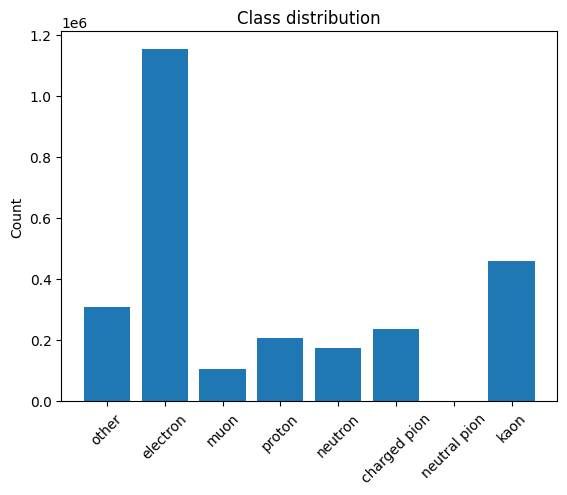

In [126]:
plt.bar(range(8), np.bincount(distribution))
plt.xticks(range(8), list(CLASS_NAMES.values()), rotation=45)
plt.ylabel("Count")
plt.title("Class distribution")